<a href="https://colab.research.google.com/github/YUFULEO/Movie-Recommendation-System/blob/main/ECE219_project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163016 sha256=eab681ed6be0c953f73250f8bfc1ce7c13f7e05ac8986dd7ca1fd2a99037bca2
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise.model_selection import cross_validate, KFold
from surprise.similarities import pearson
from surprise.prediction_algorithms import KNNWithMeans
from surprise import Reader, Dataset
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

## Explore The Dataset (Question 1)

In [ ]:
!unzip movie.zip

Archive:  movie.zip
  inflating: tags.csv                
  inflating: ratings.csv             
  inflating: movies.csv              
  inflating: links.csv               
  inflating: README.txt              


In [ ]:
movies = pd.read_csv('movies.csv', index_col=0)
ratings = pd.read_csv('ratings.csv', index_col=0)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


### Question 1.A

In [ ]:
aval_ratings = ratings.shape[0]
possible_ratings = ratings.userId.nunique() * ratings.movieId.nunique()
sparsity = aval_ratings / possible_ratings
sparsity

0.016999683055613623

**<font color=blue size=4>Question 1.A**

**- Compute the sparsity of the movie rating dataset:**

**- Sparsity = Total number of available ratings / Total number of possible ratings**

The sparsity of the movie rating dataset is 0.016999683055613623

### Question 1.B

**<font color=blue size=4>Question 1.B**

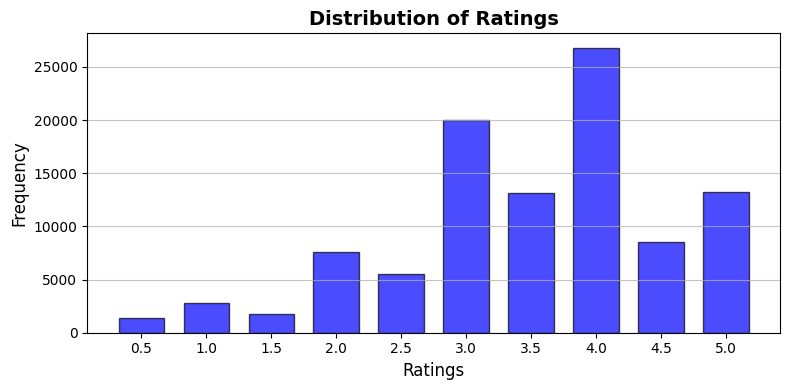

In [ ]:
bin_edges = np.linspace(0.5, 5.5, num=11)

plt.figure(figsize=(8, 4))
n, bins_out, patches = plt.hist(ratings['rating'], bins=bin_edges, color='blue',
                                rwidth=0.7, align='left', edgecolor='black', alpha=0.7)

plt.xticks(ticks=np.arange(0.5, 5.5, 0.5), labels=np.arange(0.5, 5.5, 0.5))

plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Ratings', fontsize=14, fontweight='bold')

plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

**<font color=blue size=4>Question 1.B**

**- Plot a histogram showing the frequency of the rating values: Bin the raw rating values
into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the
number of entries in the ratings matrix R that fall within each bin and use this count as the
height of the vertical axis for that particular bin. Comment on the shape of the histogram**

The histogram is shown above. You can see that most of ratings are from 3 to 5. And rating 4 have the most frequency. And from rating 0.5 to 2.5, there frequency always less than 10000.

### Question 1.C

<Axes: title={'center': 'Distribution of the number of ratings received among movies'}, xlabel='Movie Index', ylabel='number of ratings'>

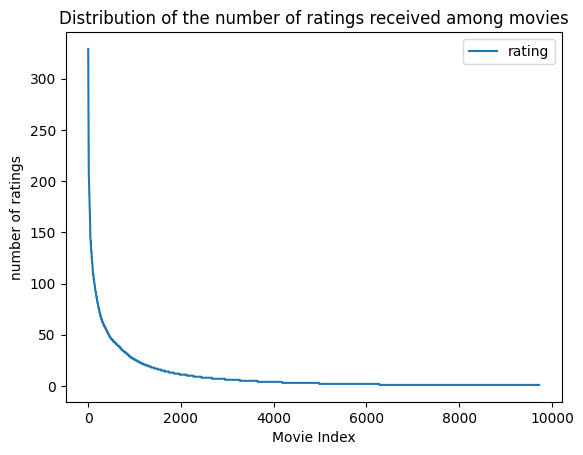

In [ ]:
movie_count_df = ratings.groupby(['movieId']).count()[['rating']].sort_values('rating', ascending=False).reset_index()
movie_count_df.plot.line(y = 'rating', ylabel = 'number of ratings',
                         xlabel = 'Movie Index',
                         title = 'Distribution of the number of ratings received among movies')

**<font color=blue size=4>Question 1.C**

**- Plot the distribution of the number of ratings received among movies: The X-axis
should be the movie index ordered by decreasing frequency and the Y -axis should be the number
of ratings the movie has received; ties can broken in any way. A monotonically decreasing trend
is expected.**

Plot is shown as above. You can see that there is a monotonically decreasing.

### Question 1.D

<Axes: title={'center': 'Distribution of the number of ratings among users'}, xlabel='User Index', ylabel='number of ratings'>

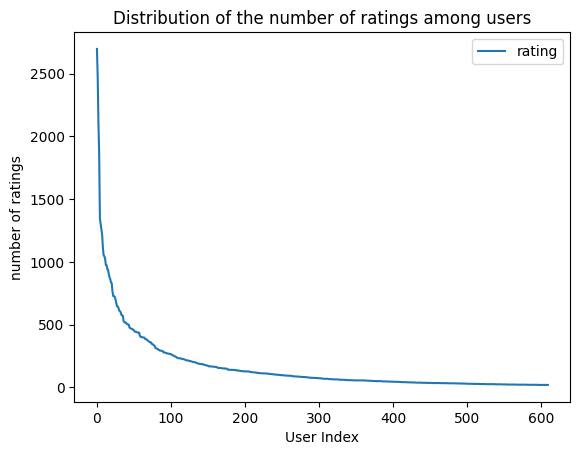

In [ ]:
user_count_df = ratings.groupby(['userId']).count()[['rating']].sort_values('rating', ascending=False).reset_index()
user_count_df.plot.line(y = 'rating', ylabel = 'number of ratings',
                         xlabel = 'User Index',
                         title = 'Distribution of the number of ratings among users')

**<font color=blue size=4>Question 1.D**

**- Plot the distribution of ratings among users: The X-axis should be the user index ordered
by decreasing frequency and the Y -axis should be the number of movies the user has rated.
The requirement of the plot is similar to that in Question C.**

Plot is shown as above. You can see that there is a monotonically decreasing.

### Question 1.E

**<font color=blue size=4>Question 1.E**

**- Discuss the salient features of the distributions from Questions C,D and their implications
for the recommendation process.**

In Problems C and D, both graphs show a monotonically decreasing trend. In problem C, we can see that there's a steep drop-off in the number of ratings per movie after the first few movies. This indicates that a small number of movies receive a large number of ratings, while a large number of movies receive very few ratings. In problem D, we can see that a small number of users rate more than 500 movies, which is very similar to the figure in problem C. Both figures indicate the sparsity of the data. New movies or users with few ratings will have less representation in the data, making it difficult for recommendation algorithms to make accurate predictions for them. And the recommender system may recommend popular movies which have a lot of ratings to the user.


### Question 1.F

In [ ]:
rating_var_df = ratings.groupby(['movieId']).var(ddof=0)[['rating']].fillna(0)

Text(0, 0.5, 'Count of Movies')

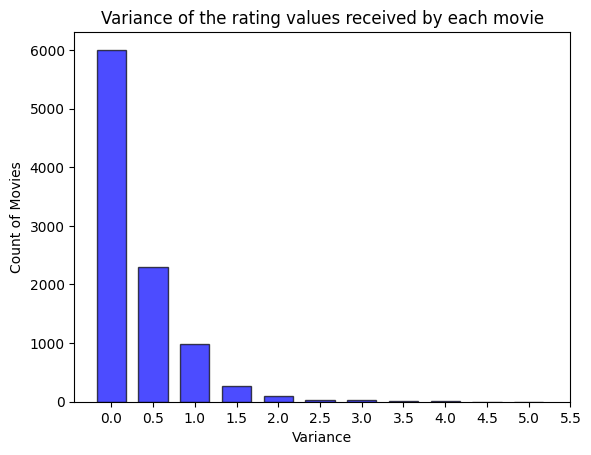

In [ ]:
plt.hist(rating_var_df.rating, bins=np.arange(0, 6, 0.5), color='blue',rwidth=0.7, align='left', edgecolor='black', alpha=0.7)
plt.xticks(np.arange(0, 6, 0.5))
plt.title('Variance of the rating values received by each movie')
plt.xlabel('Variance')
plt.ylabel('Count of Movies')

**<font color=blue size=4>Question 1.F**

**- Compute the variance of the rating values received by each movie: Bin the variance
values into intervals of width 0.5 and use the binned variance values as the horizontal axis.
Count the number of movies with variance values in the binned intervals and use this count as
the vertical axis. Briefly comment on the shape of the resulting histogram.**

The figure is the variance of the rating values received by each movie. We can see that the variance of ratings is in decrease order. And most of movies have no variance or low variance in their ratings. Almost no movies receive more than 2.5 variance in the ratings. The histogram is make sense, because users usually have the similar standards of judgment for movies.

## Neighborhood-based collaborative filtering (Question 2 - 6)

### Question 2

**<font color=blue size=4>Question 2**

**Understanding the Pearson Correlation Coefficient:**

**- A Write down the formula for $µ_u$ in terms of $I_u$ and $r_{uk}$;**

$\mu_u = \frac{\sum_{k \in I_u} r_{uk}}{|I_u|}$


**- B In plain words, explain the meaning of $I_u$ ∩ $I_v$. Can $I_u ∩ I_v$ = ∅? (Hint: Rating matrix R is
sparse)**

$I_u$ ∩ $I_v$ represents the set of items that have seen rated by both user u and user v. The rating matrix R is sparse, indicating that most movies are not rated by most users, so $I_u$ ∩ $I_v$ can be an empty set if there are no commonly rated movies between user u and user v.


### Question 3

**<font color=blue size=4>Question 3**

**- Understanding the Prediction function: Can you explain the reason behind
mean-centering the raw ratings (rvj − µv) in the prediction function? (Hint: Consider users who
either rate all items highly or rate all items poorly and the impact of these users on the prediction
function.)**

By normalizing user ratings, mean-centering takes into account biases and varying user rating scales. Regardless of the actual quality of the movie, some people may naturally be more forgiving or stricter with their evaluations. On a 5-point rating system, for instance, a user may generally give a film a 4 or 5, yet another user may only give a 3 and hardly ever go over that. Normalization allows the algorithm to determine a user's relative preference for an item more precisely than if they had a tendency to rank every item as high or low. It can help recommendation system to have more accurate prediction.

### Question 4

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)

In [ ]:
k_values = range(2, 102, 2)
avg_rmse = []
avg_mae = []

for k in k_values:
  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
  results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

  avg_rmse.append(np.mean(results['test_rmse']))
  avg_mae.append(np.mean(results['test_mae']))

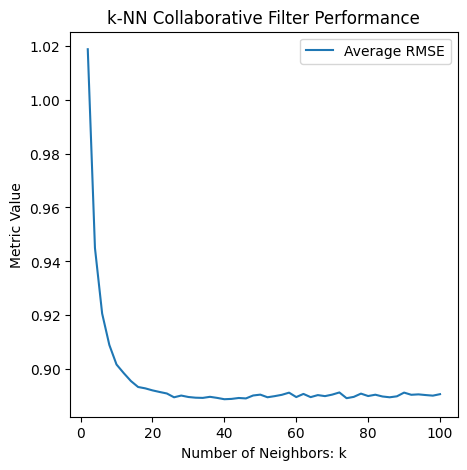

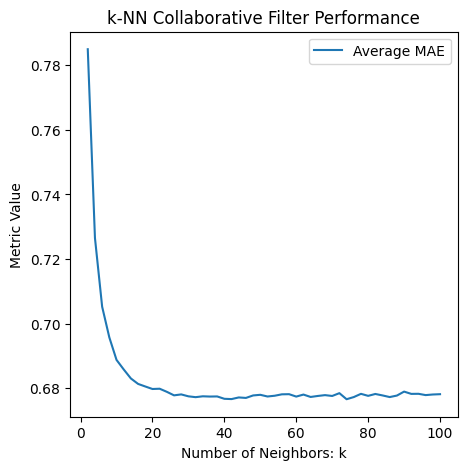

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(k_values, avg_rmse, label='Average RMSE')
plt.title('k-NN Collaborative Filter Performance')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

plt.figure(figsize= (5, 5))
plt.plot(k_values, avg_mae, label='Average MAE')
plt.title('k-NN Collaborative Filter Performance')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

**<font color=blue size=4>Question 4**

**- Design a k-NN collaborative filter to predict the ratings of the movies in the
original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of
neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average
MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis)
against k (X-axis) and average MAE (Y-axis) against k (X-axis).**

We plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis). The figures are shown above.

### Question 5

In [ ]:
for i, k in enumerate(k_values):
  if k == 20:
    break

print(f'At k = 20, average RMSE = {avg_rmse[i]}')
print(f'At k = 20, average MAE = {avg_mae[i]}')

At k = 20, average RMSE = 0.8921807741033128
At k = 20, average MAE = 0.6797424365465897


**<font color=blue size=4>Question 5**

**-  Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum
k’ in this context means that increasing k above the minimum value would not result in a significant
decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would
correspond to the k value for which average RMSE and average MAE converges to a steady-state
value. Please report the steady state values of average RMSE and average MAE.**

According to the plot from question 4, we found the minimum k is 20. When k = 20, we find the corresponding average RMSE and average MAE value. The average RMSE = 0.8921807741033128. The average MAE = 0.6797424365465897.

### Question 6

In [ ]:
movie_count = ratings.groupby('movieId').count()[['rating']]
popular_movie_index = movie_count[movie_count['rating'] > 2].index

high_var_index_count = movie_count[movie_count['rating'] >= 5].index
ratings_high_var = ratings[ratings['movieId'].isin(high_var_index_count)]
movie_var = ratings.groupby('movieId').var(ddof=0)[['rating']]
high_var_index = movie_var[movie_var['rating'] >= 2].index

In [ ]:
ratings_popular = ratings[ratings['movieId'].isin(popular_movie_index)]
ratings_unpopular = ratings[~ratings['movieId'].isin(popular_movie_index)]
ratings_high_var = ratings_high_var[ratings_high_var['movieId'].isin(high_var_index)]

In [ ]:
def plot_report_rmse(df):
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)
  k_values = range(2, 102, 2)
  avg_rmse = []

  for k in k_values:
    algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)

    avg_rmse.append(np.mean(results['test_rmse']))

  print(f'The minimum average RMSE is {min(avg_rmse)}')

  plt.figure(figsize=(5, 5))
  plt.plot(k_values, avg_rmse, label='Average RMSE')
  plt.title('k-NN Collaborative Filter Performance')
  plt.xlabel('Number of Neighbors: k')
  plt.ylabel('Metric Value')
  plt.legend()
  plt.show()

The minimum average RMSE is 0.8690602546163891


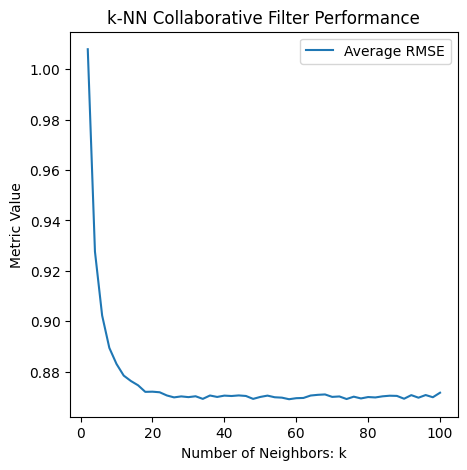

In [ ]:
plot_report_rmse(ratings_popular)

The minimum average RMSE is 1.0536221916042083


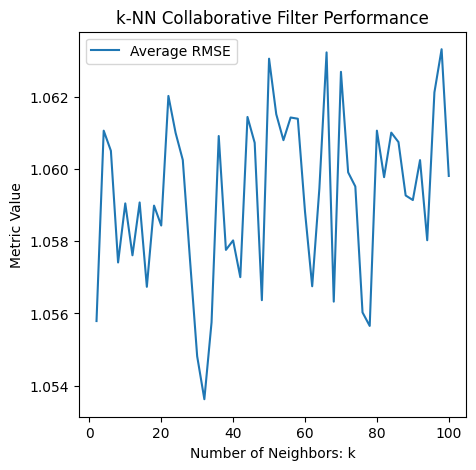

In [ ]:
plot_report_rmse(ratings_unpopular)

The minimum average RMSE is 1.4514823789623033


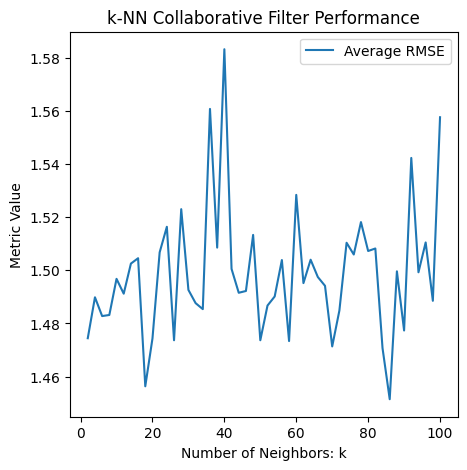

In [ ]:
plot_report_rmse(ratings_high_var)

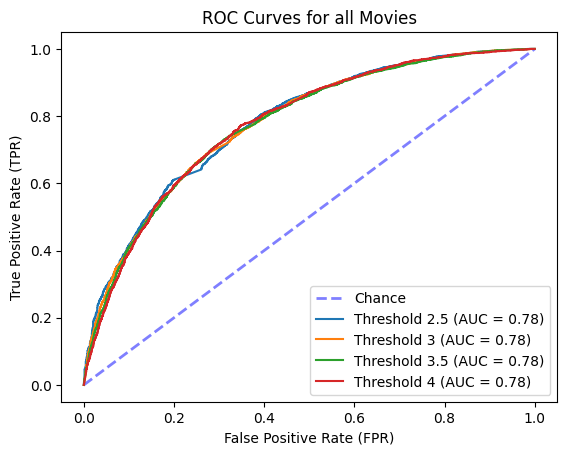

In [ ]:
k = 20
thresholds = [2.5, 3, 3.5, 4]

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
for threshold in thresholds:
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
  train_, test_ = train_test_split(data, test_size=0.1, random_state=42)\

  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
  algo.fit(train_)
  preds = algo.test(test_)
  y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
  y_scores = [pred.est for pred in preds]

  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
  plt.title(f'ROC Curves for all Movies')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")

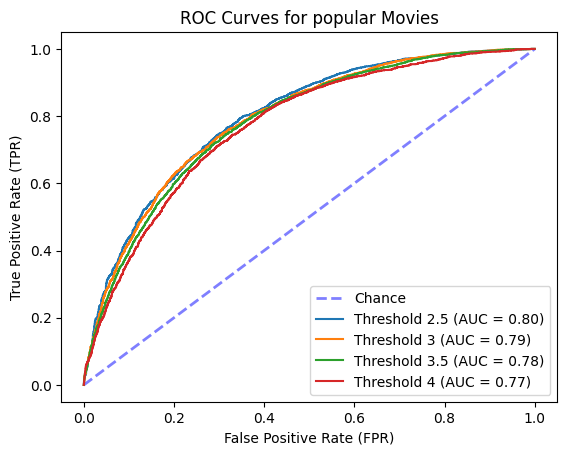

In [ ]:
k = 20
thresholds = [2.5, 3, 3.5, 4]

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
for threshold in thresholds:
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(ratings_popular[['userId', 'movieId', 'rating']], reader=reader)
  train_, test_ = train_test_split(data, test_size=0.1, random_state=42)\

  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
  algo.fit(train_)
  preds = algo.test(test_)
  y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
  y_scores = [pred.est for pred in preds]

  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
  plt.title(f'ROC Curves for popular Movies')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")

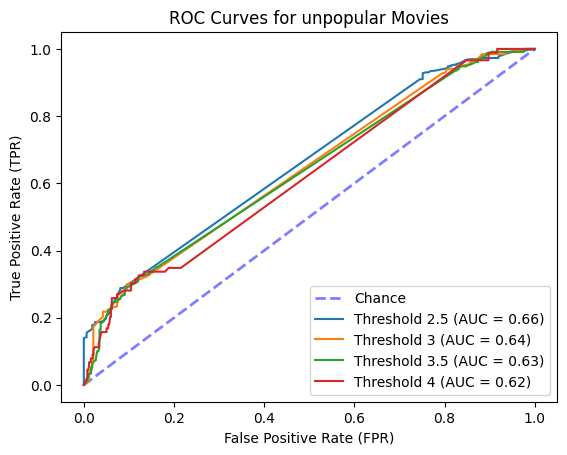

In [ ]:
k = 20
thresholds = [2.5, 3, 3.5, 4]

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
for threshold in thresholds:
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(ratings_unpopular[['userId', 'movieId', 'rating']], reader=reader)
  train_, test_ = train_test_split(data, test_size=0.1, random_state=42)\

  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
  algo.fit(train_)
  preds = algo.test(test_)
  y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
  y_scores = [pred.est for pred in preds]

  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
  plt.title(f'ROC Curves for unpopular Movies')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")

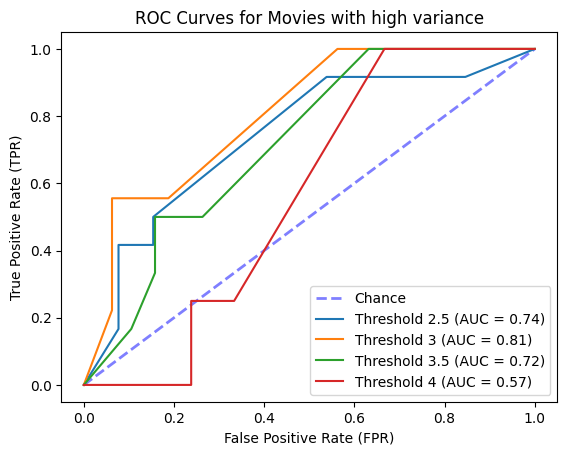

In [ ]:
k = 20
thresholds = [2.5, 3, 3.5, 4]

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
for threshold in thresholds:
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(ratings_high_var[['userId', 'movieId', 'rating']], reader=reader)
  train_, test_ = train_test_split(data, test_size=0.1, random_state=42)\

  algo = KNNWithMeans(k=k, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
  algo.fit(train_)
  preds = algo.test(test_)
  y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
  y_scores = [pred.est for pred in preds]

  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
  plt.title(f'ROC Curves for Movies with high variance')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")

**<font color=blue size=4>Question 6**

**- Within EACH of the 3 trimmed subsets in the dataset, design (train and
validate):**

**- A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance)
and evaluate each of the three models’ performance using 10-fold cross validation:**

**• Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute
the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE
(Y-axis) against k (X-axis). Also, report the minimum average RMSE.**

We plot the images for three trimmings. You can find the figures above. For popular, the minimum average RMSE is 0.8690602546163891. For unpopular, the minimum average RMSE is 1.0536221916042083. For high-variance, the minimum average RMSE is 1.4514823789623033.

**• Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These
thresholds are applied only on the ground truth labels in held-out validation set. For each of
the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in
this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds
can be condensed into one plot per trimming option yielding only 4 plots.**

We plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. And for each of the plots, we also report the area under the curve (AUC) value. The figures are shown above.


## Model-based collaborative filtering (Question 7 - 10)

### Question 7

**<font color=blue size=4>Question 7**

**- Understanding the NMF cost function: Is the optimization problem given by
equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate
it as a least-squares problem.**

No. The optimization problem given by equation 5 is not convex. We are given the equation 5, which is:

$$
\min_{U,V} \sum_{i=1}^{m}\sum_{j=1}^{n} W_{ij}(r_{ij} - (UV^\top)_{ij})^2
$$

A quadratic function of the entries of matrices U and V makes up each term in this function, which is the sum of squared terms in this instance. Since it is the square of a linear function of the parameters, it is a convex function if we were to examine each term separately with regard to either U or V. But when you look at U and V together, it's not convex.  The bilinear term that the function forms is:

$$ UV^\top$$

A bilinear term's square is not a convex function. Stated differently, the problem is convex if we only optimize over V after fixing U, or vice versa. However, it is not convex as there are two variables to optimize at the same time, U and V.


### Question 8.A

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
k_values = range(2, 50, 2)
avg_rmse = []
avg_mae = []
for k in k_values:
  nmf = NMF(n_factors=k)
  results = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
  avg_rmse.append(np.mean(results['test_rmse']))
  avg_mae.append(np.mean(results['test_mae']))

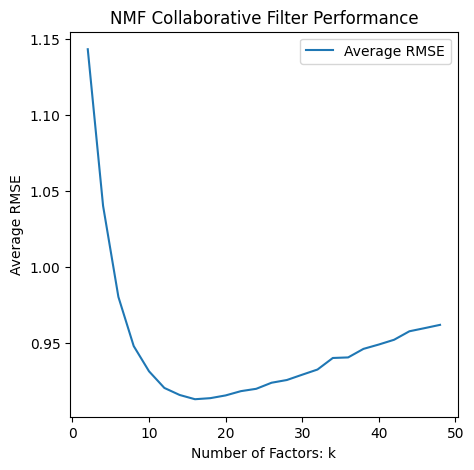

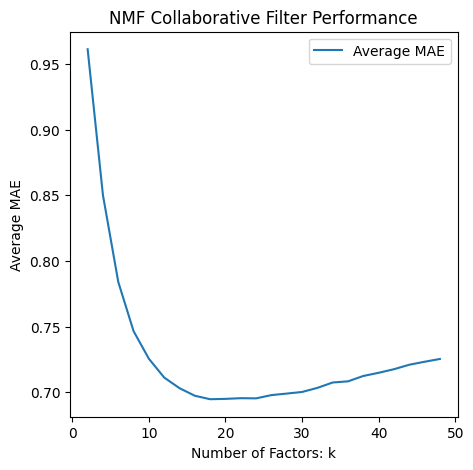

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(k_values, avg_rmse, label='Average RMSE')
plt.title('NMF Collaborative Filter Performance')
plt.xlabel('Number of Factors: k')
plt.ylabel('Average RMSE')
plt.legend()
plt.show()

plt.figure(figsize= (5, 5))
plt.plot(k_values, avg_mae, label='Average MAE')
plt.title('NMF Collaborative Filter Performance')
plt.xlabel('Number of Factors: k')
plt.ylabel('Average MAE')
plt.legend()
plt.show()

**<font color=blue size=4>Question 8.A**

**- Design a NMF-based collaborative filter to predict the ratings of the movies in the original
dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and
average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes
too long, you can increase the step size. Increasing it too much will result in poorer granularity
in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). For solving this question, use the default value for the regularization
parameter.**

We designed a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Then we plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Yaxis) against k (X-axis). There are two separate figures as shown above.


### Question 8.B

In [ ]:
for i, rmse in enumerate(avg_rmse):
  if rmse == min(avg_rmse):
    break
print(f'Minimum average RMSE at k = {k_values[i]}: {min(avg_rmse)}')

for i, rmse in enumerate(avg_mae):
  if rmse == min(avg_mae):
    break
print(f'Minimum average MAE at k = {k_values[i]}: {min(avg_mae)}')

Minimum average RMSE at k = 16: 0.9131745413012256
Minimum average MAE at k = 18: 0.6947906550475651


In [ ]:
num_genres = len(set(sum([i.split('|') for i in movies.genres.unique()], [])))
print(f'Number of movie genres: {num_genres}')

Number of movie genres: 20


**<font color=blue size=4>Question 8.B**

**-  Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?**

We use the plot from the previous part to find the optimal number of latent factors. For RMSE, the k is 16, and the corresponding minimum average RMSE is 0.9131745413012256. For MAE, the k is 18, and the corresponding minimum average MAE is 0.6947906550475651. Then we find the number of movie genres is 20. The optimal number of latent factors (16 and 18) is very close to the number of movie genres.


### Question 8.C

In [ ]:
def plot_report_rmse_nmf(df, title):
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)
  k_values = range(2, 50, 2)
  avg_rmse = []

  for k in k_values:
    nmf = NMF(n_factors=k)
    results = cross_validate(nmf, data, measures=['RMSE'], cv=10, verbose=False)

    avg_rmse.append(np.mean(results['test_rmse']))

  print(f'The minimum average RMSE is {min(avg_rmse)}')

  plt.figure(figsize=(5, 5))
  plt.plot(k_values, avg_rmse, label='Average RMSE')
  plt.title(f'NMF Performance for {title} subset')
  plt.xlabel('Number of Factors: k')
  plt.ylabel('Average RMSE')
  plt.legend()
  plt.show()

def plot_roc_nmf(k, df, title):
  thresholds = [2.5, 3, 3.5, 4]

  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
  for threshold in thresholds:
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)
    train_, test_ = train_test_split(data, test_size=0.1, random_state=42)

    algo = NMF(n_factors = k)
    algo.fit(train_)
    preds = algo.test(test_)
    y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
    y_scores = [pred.est for pred in preds]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
    plt.title(f'ROC Curves for {title} Movies')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="lower right")

The minimum average RMSE is 0.8920974022017554


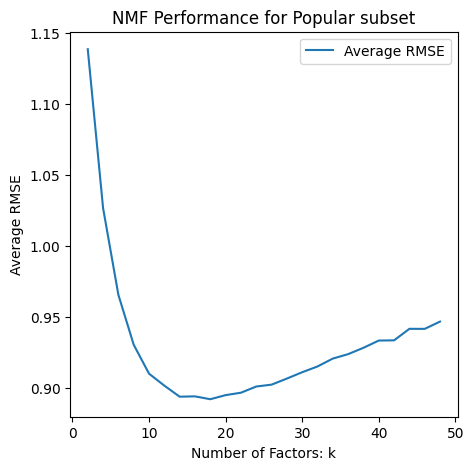

In [ ]:
plot_report_rmse_nmf(ratings_popular, "Popular")

The minimum average RMSE is 1.1285430474022573


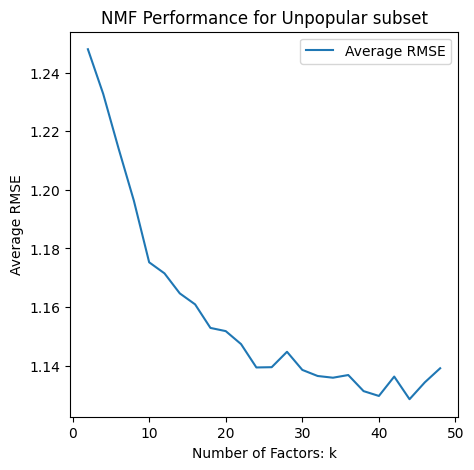

In [ ]:
plot_report_rmse_nmf(ratings_unpopular, "Unpopular")

The minimum average RMSE is 1.592200170086227


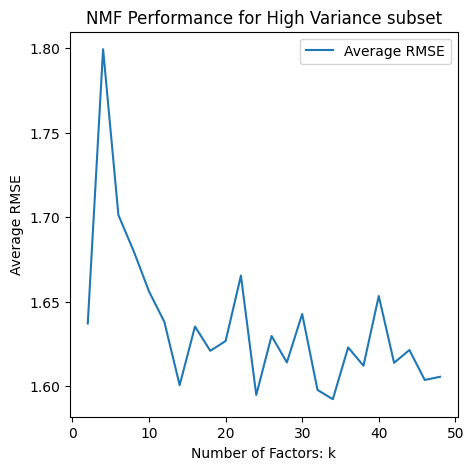

In [ ]:
plot_report_rmse_nmf(ratings_high_var, "High Variance")

In [ ]:
k = 18

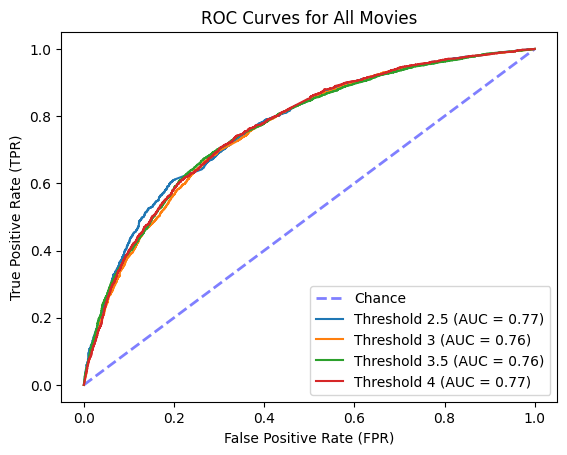

In [ ]:
plot_roc_nmf(k, ratings, 'All')

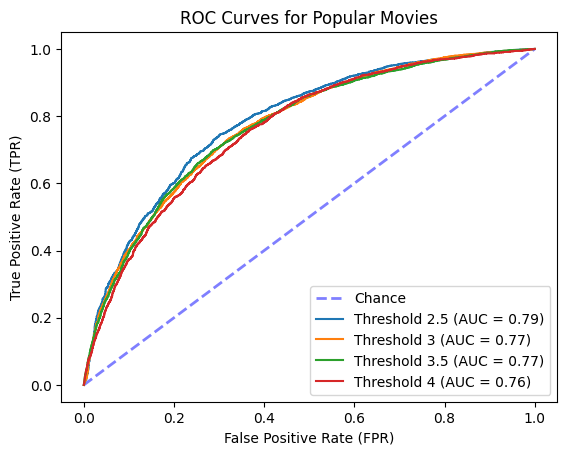

In [ ]:
plot_roc_nmf(k, ratings_popular, 'Popular')

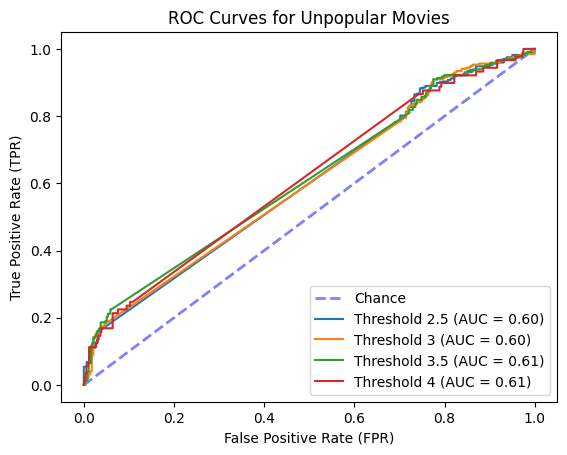

In [ ]:
plot_roc_nmf(k, ratings_unpopular, 'Unpopular')

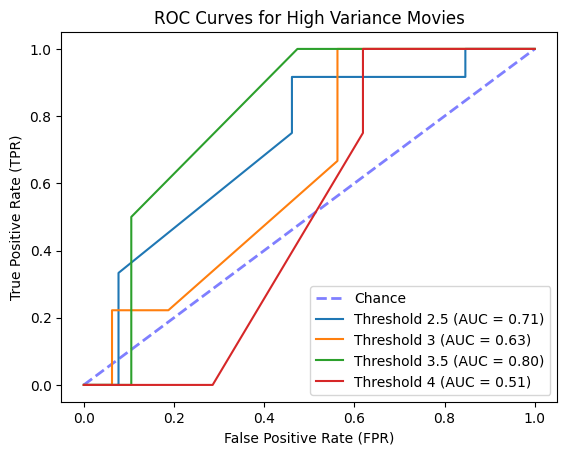

In [ ]:
plot_roc_nmf(k, ratings_high_var, 'High Variance')

**<font color=blue size=4>Question 8.C**

**- Performance on trimmed dataset subsets: For each of Popular, Unpopular and HighVariance subsets -
– Design a NMF collaborative filter for each trimmed subset and evaluate its performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step
sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE
across all 10 folds.
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.**

For each of Popular, Unpopular and HighVariance subsets, we plot average RMSE (Y-axis) against k (X-axis). The figures are shown above. For popular, the minimum average RMSE is 0.8920974022017554. For unpopular, the minimum average RMSE is 1.1285430474022573. For high variance subset, the minimum average RMSE is 1.592200170086227.

**• Plot the ROC curves for the NMF-based collaborative filter and also report the area under the
curve (AUC) value as done in Question 6.**

We also plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value. You can find them above.


### Question 9

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
train_, test_ = train_test_split(data, test_size=0.1, random_state=42)
nmf = NMF(n_factors=20).fit(train_)
nmf.test(test_)
matrix_U = nmf.pu
matrix_V = nmf.qi

In [ ]:
movie_latent_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.655497,0.747581,0.325531,0.448807,0.169912,0.679382,0.448461,0.541133,0.614213,0.438529,0.450715,0.459130,0.136932,0.948060,0.400075,0.805132,0.411471,0.296642,0.105452,0.477608
1,0.415140,0.540833,0.160351,0.082264,0.013762,0.240909,0.293569,0.286367,0.202618,0.262386,0.197047,0.481254,0.148937,0.158274,0.612349,0.758458,0.848737,0.415154,0.263060,0.616940
2,0.591079,1.063994,0.331498,0.492118,0.467597,0.897869,0.015601,0.029877,0.111783,0.222799,0.394278,0.274249,0.062236,0.005540,0.022946,0.054088,0.477358,0.076487,0.261550,0.008016
3,0.145191,0.371800,0.440006,0.329042,0.442705,0.523264,0.157005,0.318656,0.730657,0.680851,0.500095,0.562191,0.175897,0.219563,0.282492,0.464673,0.729819,0.627251,0.441880,0.354872
4,0.596714,0.524693,0.896947,0.363545,0.309669,0.659204,0.532967,0.404658,0.934820,0.501021,0.507194,0.316748,0.618011,0.461592,0.004730,0.633959,0.040302,0.846876,0.084321,0.582132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9378,0.051436,0.002880,0.020735,0.028078,0.061310,0.074672,0.085250,0.105834,0.093884,0.072431,0.014028,0.043450,0.011521,0.079046,0.039317,0.098742,0.012184,0.086177,0.093692,0.081629
9379,0.401380,0.202497,0.439116,0.095410,0.107393,0.549123,0.032319,0.356340,0.406099,0.228616,0.451845,0.232145,0.130500,0.042240,0.109522,0.324465,0.470143,0.278834,0.084162,0.497344
9380,0.461712,0.295328,0.688782,0.697817,0.575458,0.745105,0.467642,0.745792,0.174634,0.784363,0.253347,0.405051,0.283119,0.582732,0.196916,0.566656,0.405632,0.367108,0.031091,0.171191
9381,0.449377,0.427087,0.305690,0.614991,0.369789,0.375534,0.605051,0.016102,0.650744,0.338197,0.331598,0.620267,0.648658,0.580839,0.165378,0.572425,0.552919,0.491422,0.212627,0.544791


In [ ]:
movie_latent_df = pd.DataFrame(matrix_V)
for col in movie_latent_df:
  genre_df = movie_latent_df[[col]]
  top_10_movie_index = genre_df.sort_values(by=[col], ascending=False).head(10).index

  top_10_movie_genres = []
  for i in top_10_movie_index:
    top_10_movie_genres.append(movies.iloc[i].genres)
  print(f'For matrix V column {col}, the genres of the top 10 movies are:')
  print(list(top_10_movie_genres))
  top_10_movie_genres_set = set(pd.Series(top_10_movie_genres).str.split('|').sum())
  print(f'The top 10 movies belong to these genres: {top_10_movie_genres_set}')
  print(f'There are {len(top_10_movie_genres_set)} unique genres.')
  print('--------------------')

For matrix V column 0, the genres of the top 10 movies are:
['Drama', 'Fantasy|Horror|Mystery|Thriller', 'Action|Sci-Fi', 'Romance', 'Drama|Fantasy|Romance', 'Comedy', 'Drama', 'Comedy|Drama|Romance', 'Drama|Thriller', 'Crime|Drama']
The top 10 movies belong to these genres: {'Thriller', 'Mystery', 'Sci-Fi', 'Comedy', 'Crime', 'Drama', 'Action', 'Fantasy', 'Horror', 'Romance'}
There are 10 unique genres.
--------------------
For matrix V column 1, the genres of the top 10 movies are:
['Comedy|Romance', 'Drama|Romance|Sci-Fi', 'Drama', 'Comedy|Drama', 'Crime|Drama|Thriller', 'Romance', 'Comedy|Fantasy|Romance', 'Drama', 'Drama|Romance', 'Drama|Thriller']
The top 10 movies belong to these genres: {'Thriller', 'Comedy', 'Sci-Fi', 'Crime', 'Drama', 'Fantasy', 'Romance'}
There are 7 unique genres.
--------------------
For matrix V column 2, the genres of the top 10 movies are:
['Action|Crime|Thriller', 'Comedy|Romance', 'Comedy|Romance', 'Drama', 'Adventure|Animation|Children|Comedy|Musical

**<font color=blue size=4>Question 9**

**- Interpreting the NMF model: Perform Non-negative matrix factorization on
the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent
factors interaction and V represents the movie-latent factors interaction (use k = 20). For each
column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the
top 10 movies belong to a particular or a small collection of genre? Is there a connection between
the latent factors and the movie genres?**

We perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , we sort the movies in descending order and report the genres of the top 10 movies. Results of all columns can be found above. We try to find a connection between the latent factors and the movie genres. For latent factor 0, most of movies have the Romance and Drama genres, which means that the latent factor 0 may represent the combination fo Romance and Drama movies. For latent factor 7, most of movies have the Commedy and Drama genres, which means that the latent factor 7 may represent the combination fo Commedy and Drama movies. For latent factor 18, most of movies have the Thriller and Drama genres, which means that the latent factor 18 may represent the combination fo Thriller and Drama movies. To summary, each latent factor may represent the different combination of genres.


### Question 10.A

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
k_values = range(2, 50, 2)
avg_rmse = []
avg_mae = []
for k in k_values:
  svd = SVD(n_factors=k)
  results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
  avg_rmse.append(np.mean(results['test_rmse']))
  avg_mae.append(np.mean(results['test_mae']))

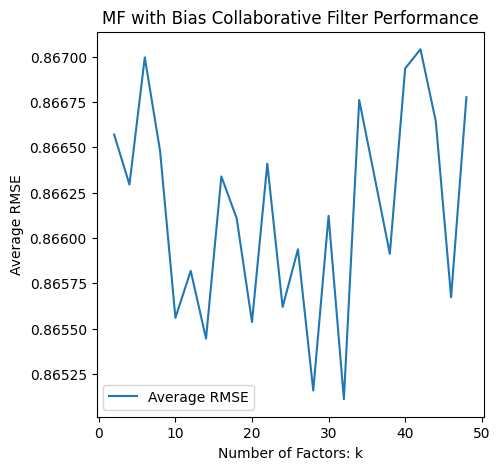

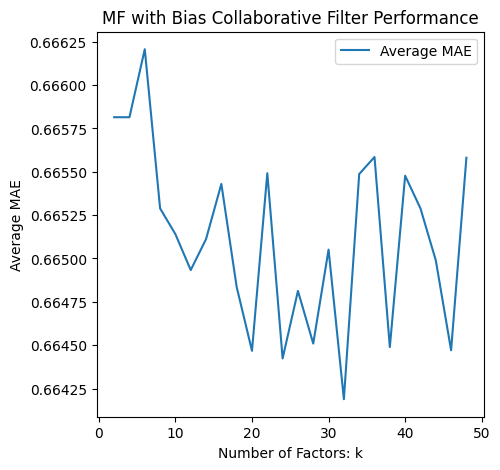

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(k_values, avg_rmse, label='Average RMSE')
plt.title('MF with Bias Collaborative Filter Performance')
plt.xlabel('Number of Factors: k')
plt.ylabel('Average RMSE')
plt.legend()
plt.show()

plt.figure(figsize= (5, 5))
plt.plot(k_values, avg_mae, label='Average MAE')
plt.title('MF with Bias Collaborative Filter Performance')
plt.xlabel('Number of Factors: k')
plt.ylabel('Average MAE')
plt.legend()
plt.show()

**<font color=blue size=4>Question 10.A**

**- Design a MF-based collaborative filter to predict the ratings of the movies in the original
dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of
latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE
and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the
average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis).
For solving this question, use the default value for the regularization parameter.**

These plots are shown above. For the MF-based collaborative filter method, we use matrix factorization SVD from
surprise prediction package. These plots are quite different compare with before.


### Question 10.B

In [ ]:
for i, rmse in enumerate(avg_rmse):
  if rmse == min(avg_rmse):
    break
print(f'Minimum average RMSE at k = {k_values[i]}: {min(avg_rmse)}')

for i, rmse in enumerate(avg_mae):
  if rmse == min(avg_mae):
    break
print(f'Minimum average MAE at k = {k_values[i]}: {min(avg_mae)}')

Minimum average RMSE at k = 32: 0.8651097138980364
Minimum average MAE at k = 32: 0.6641882305172834


In [ ]:
num_genres = len(set(sum([i.split('|') for i in movies.genres.unique()], [])))
print(f'Number of movie genres: {num_genres}')

Number of movie genres: 20


**<font color=blue size=4>Question 10.B**

**- Use the plot from the previous part to find the optimal number of latent factors. Optimal
number of latent factors is the value of k that gives the minimum average RMSE or the
minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal
number of latent factors same as the number of movie genres?**


We use the plot from the previous part to find the optimal number of latent factors. The optimal number of latent factors is 32 for both RMSE and MAE. For RMSE, minimum average RMSE at k = 32 is 0.8651097138980364. For MAE, minimum average MAE at k = 32: 0.6641882305172834. The optimal number of latent factors is not the same as the number of movie genres, because the number of movie genres is 20. So the latent factor in the model is not interpretable.

### Question 10.C

In [ ]:
def plot_report_rmse_mfb(df, title):
  reader = Reader(rating_scale=(0.5, 5))
  data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)
  k_values = range(2, 50, 2)
  avg_rmse = []

  for k in k_values:
    mfb = SVD(n_factors=k)
    results = cross_validate(mfb, data, measures=['RMSE'], cv=10, verbose=False)

    avg_rmse.append(np.mean(results['test_rmse']))

  print(f'The minimum average RMSE is {min(avg_rmse)}')

  plt.figure(figsize=(5, 5))
  plt.plot(k_values, avg_rmse, label='Average RMSE')
  plt.title(f'MF with Bias Performance for {title} subset')
  plt.xlabel('Number of Factors: k')
  plt.ylabel('Average RMSE')
  plt.legend()
  plt.show()

def plot_roc_mfb(k, df, title):
  thresholds = [2.5, 3, 3.5, 4]

  fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)
  for threshold in thresholds:
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader=reader)
    train_, test_ = train_test_split(data, test_size=0.1, random_state=42)

    algo = SVD(n_factors = k)
    algo.fit(train_)
    preds = algo.test(test_)
    y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
    y_scores = [pred.est for pred in preds]

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')
    plt.title(f'ROC Curves for {title} Movies')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="lower right")

The minimum average RMSE is 0.8555654652414104


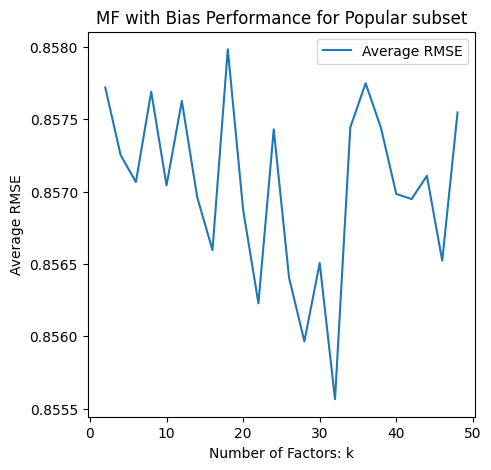

In [ ]:
plot_report_rmse_mfb(ratings_popular, "Popular")

The minimum average RMSE is 0.8950603364709302


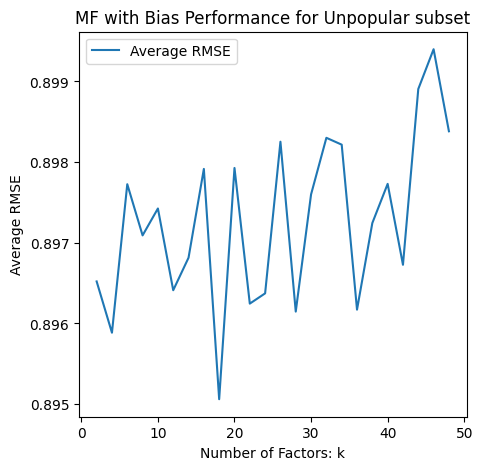

In [ ]:
plot_report_rmse_mfb(ratings_unpopular, "Unpopular")

The minimum average RMSE is 1.5594003476490172


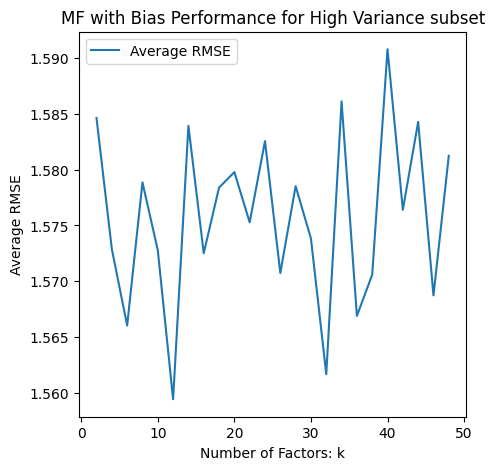

In [ ]:
plot_report_rmse_mfb(ratings_high_var, "High Variance")

In [ ]:
k = 32

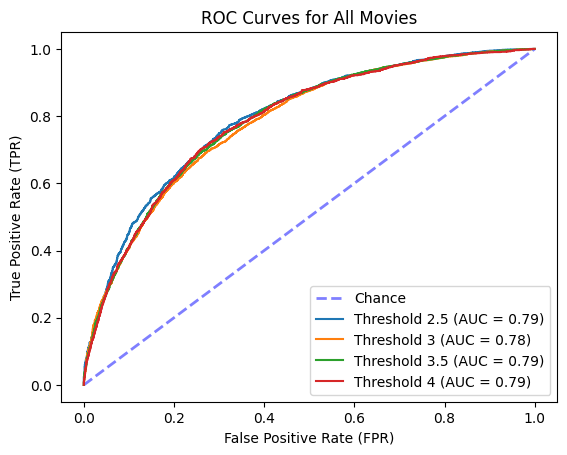

In [ ]:
plot_roc_mfb(k, ratings, 'All')

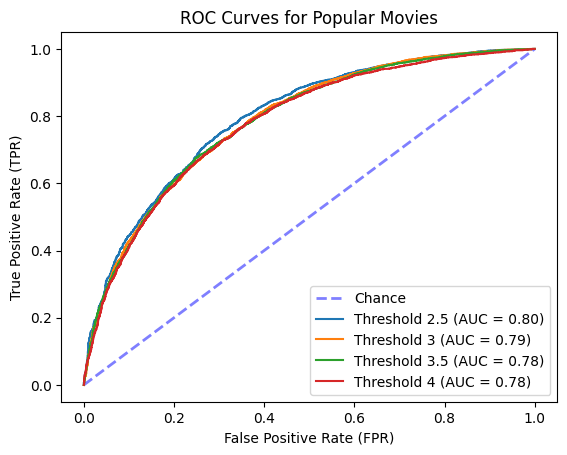

In [ ]:
plot_roc_mfb(k, ratings_popular, 'Popular')

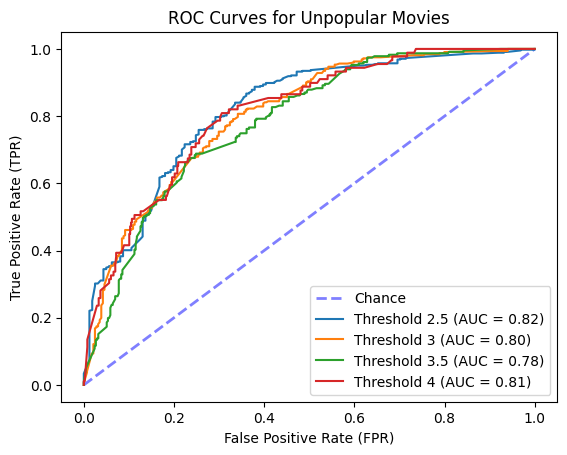

In [ ]:
plot_roc_mfb(k, ratings_unpopular, 'Unpopular')

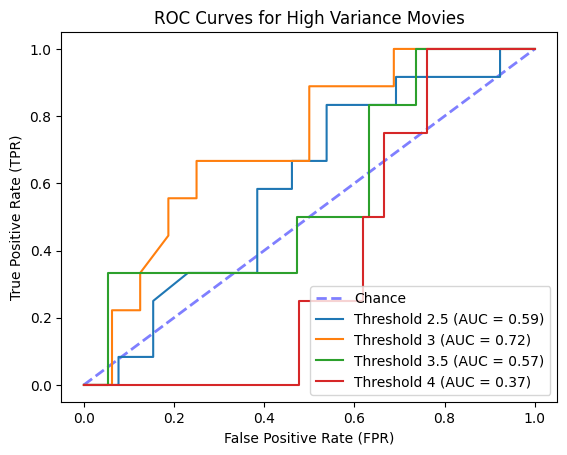

In [ ]:
plot_roc_mfb(k, ratings_high_var, 'High Variance')

**<font color=blue size=4>Question 10.C**

**- Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets
-
– Design a MF collaborative filter for each trimmed subset and evaluate its performance
using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step
sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE
across all 10 folds.
– Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.**

We plot average RMSE (Y-axis) against k (X-axis) and also report the minimum average RMSE for each of Popular, Unpopular and High-Variance subsets. For popular, the minimum average RMSE is 0.8555654652414104. For unpopular, the minimum average RMSE is 0.8950603364709302. For high variance, the minimum average RMSE is 1.5594003476490172.

**• Plot the ROC curves for the MF-based collaborative filter and also report the area under the
curve (AUC) value as done in Question 6.**

We also plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6. And we use k = 32 as we found in question 10.A. You can find these figures above.


## Naive collaborative filtering

### Question 11

In [ ]:
from surprise import AlgoBase

class NaivePrediction(AlgoBase):
    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)

    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)

        # Compute the average rating. We might as well use the
        # trainset.global_mean attribute ;)
        self.the_mean = np.mean([r for (_, _, r) in self.trainset.all_ratings()])

        return self

    def estimate(self, u, i):

        return self.the_mean

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)

algo = NaivePrediction()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
avg_rmse = np.mean(results['test_rmse'])
print(f'The avergae RMSE is {avg_rmse}')

The avergae RMSE is 0.8672915170085836


In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_popular[['userId', 'movieId', 'rating']], reader=reader)

algo = NaivePrediction()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
avg_rmse = np.mean(results['test_rmse'])
print(f'The avergae RMSE for the popular movie subset is {avg_rmse}')

The avergae RMSE for the popular movie subset is 0.8585457196573186


In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_unpopular[['userId', 'movieId', 'rating']], reader=reader)

algo = NaivePrediction()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
avg_rmse = np.mean(results['test_rmse'])
print(f'The avergae RMSE for the unpopular movie subset is {avg_rmse}')

The avergae RMSE for the unpopular movie subset is 0.8973481882054195


In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_high_var[['userId', 'movieId', 'rating']], reader=reader)

algo = NaivePrediction()
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
avg_rmse = np.mean(results['test_rmse'])
print(f'The avergae RMSE for the high variance movie subset is {avg_rmse}')

The avergae RMSE for the high variance movie subset is 1.565584035873938


**<font color=blue size=4>Question 11**

**• Design a naive collaborative filter to predict the ratings of the movies in the original dataset
and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by
averaging the RMSE across all 10 folds. Report the average RMSE.**

We designed a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. For original dataset, the avergae RMSE is 0.8672915170085836

**• Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test
subsets -
– Design a naive collaborative filter for each trimmed set and evaluate its performance using
10-fold cross validation.
– Compute the average RMSE by averaging the RMSE across all 10 folds. Report the
average RMSE.**

We also designed a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation. We also compute the average RMSE by averaging the RMSE across all 10 folds. For popular, the avergae RMSE for the popular movie subset is 0.8585457196573186. For unpopular, the avergae RMSE for the unpopular movie subset is 0.8973481882054195. For high variance, the avergae RMSE for the high variance movie subset is 1.565584035873938.

## Performance comparison

### Question 12

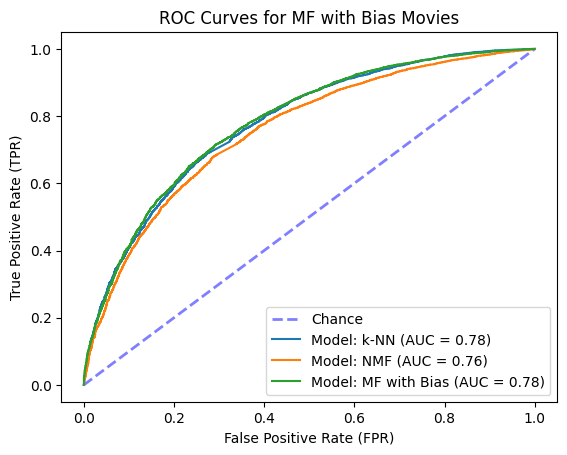

In [ ]:
models_dict = {'k-NN': KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True}, verbose=False),
               'NMF': NMF(n_factors=18),
               'MF with Bias': SVD(n_factors = 32)}
threshold = 3

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b', label='Chance', alpha=.5)

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader=reader)
train_, test_ = train_test_split(data, test_size=0.1, random_state=42)
for title, algo in models_dict.items():
  algo.fit(train_)
  preds = algo.test(test_)
  y_true = [1 if pred.r_ui > threshold else 0 for pred in preds]
  y_scores = [pred.est for pred in preds]

  fpr, tpr, _ = roc_curve(y_true, y_scores)
  roc_auc = auc(fpr, tpr)
  ax.plot(fpr, tpr, label=f'Model: {title} (AUC = {roc_auc:.2f})')
  plt.title(f'ROC Curves for {title} Movies')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc="lower right")

**<font color=blue size=4>Question 12**

**- Comparing the most performant models across architecture: Plot the
best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters
in the same figure. Use the figure to compare the performance of the filters in predicting the ratings
of the movies.**

We plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. You can see the figure above. For K-NN model, the AUC is 0.78. For NMF model, the AUC is 0.76. For MF with Bias model, the AUC is 0.78. We can know K-NN and MF with Bias have the better performance of the filters in predicting the rating of the movies. NMF have lower AUC score compare with the K-NN and MF with Bias, but it is very close to these two models.

## Ranking

### Question 13

In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np

# Load the dataset for one fold
def load_one_fole(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True)
    _, group_test = np.unique(qid_test, return_counts=True)
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
def get_feature_importance(model, importance_type='gain'):
    return model.booster_.feature_importance(importance_type=importance_type)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/MSLR-WEB10K.zip

Archive:  gdrive/MyDrive/MSLR-WEB10K.zip
   creating: Fold1/
  inflating: Fold1/test.txt          
  inflating: Fold1/train.txt         
  inflating: Fold1/vali.txt          
   creating: Fold2/
  inflating: Fold2/test.txt          
  inflating: Fold2/train.txt         
  inflating: Fold2/vali.txt          
   creating: Fold3/
  inflating: Fold3/test.txt          
  inflating: Fold3/train.txt         
  inflating: Fold3/vali.txt          
   creating: Fold4/
  inflating: Fold4/test.txt          
  inflating: Fold4/train.txt         
  inflating: Fold4/vali.txt          
   creating: Fold5/
  inflating: Fold5/test.txt          
  inflating: Fold5/train.txt         
  inflating: Fold5/vali.txt          


In [ ]:
X_train_1, y_train_1, qid_train_1, group_train_1, X_test_1, y_test_1, qid_test_1, group_test_1 = load_one_fole('Fold1/')
X_train_2, y_train_2, qid_train_2, group_train_2, X_test_2, y_test_2, qid_test_2, group_test_2 = load_one_fole('Fold2/')
X_train_3, y_train_3, qid_train_3, group_train_3, X_test_3, y_test_3, qid_test_3, group_test_3 = load_one_fole('Fold3/')
X_train_4, y_train_4, qid_train_4, group_train_4, X_test_4, y_test_4, qid_test_4, group_test_4 = load_one_fole('Fold4/')
X_train_5, y_train_5, qid_train_5, group_train_5, X_test_5, y_test_5, qid_test_5, group_test_5 = load_one_fole('Fold5/')

In [ ]:
len(np.unique(np.concatenate([qid_train_1,  qid_test_1,
          qid_train_2,  qid_test_2,
          qid_train_3,  qid_test_3,
          qid_train_4,  qid_test_4,
          qid_train_5,  qid_test_5])))

10000

In [ ]:
counts = pd.Series(np.concatenate([y_train_1, y_train_2, y_train_3, y_train_4, y_train_5
                                   ,y_test_1, y_test_2, y_test_3, y_test_4, y_test_5
                                   ])).value_counts().to_list()

<BarContainer object of 5 artists>

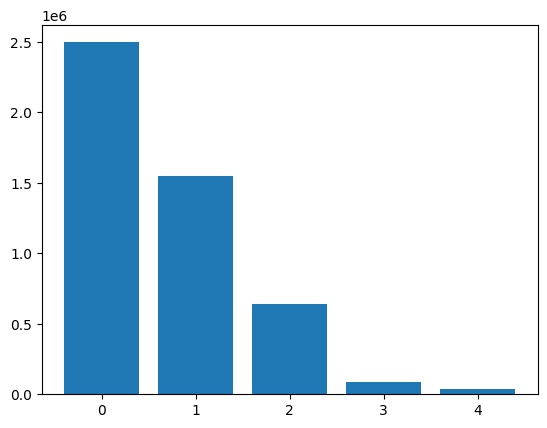

In [ ]:
plt.bar([0, 1, 2, 3, 4], counts)

**<font color=blue size=4>Question 13**

**- Data Understanding and Preprocessing:**

**• Use the provided helper code for loading and pre-processing Web10k data.**

**• Print out the number of unique queries in total and show distribution of relevance labels.**

We use the helper code for loading and pre-processing Web10k data. We also porint out the number of unique queries in total. There are 10000 unique queries in total. We concatenate the train and test dataset for each of these five folders. And we also show the distribution of relevance labels above. You can find the figure above. You can see that most of relevance labels are 0, and there a few 4 relevance labels.


### Question 14

In [ ]:
def train_and_evaluate_lightgbm(X_train, y_train, group_train, X_test, y_test, qid_test):
    model = lgb.LGBMRanker(objective='lambdarank', metric = 'ndcg', verbose=0).fit(X_train, y_train, group=group_train)
    ndcg_at_3 = compute_ndcg_all(model, X_test, y_test, qid_test, k=3)
    ndcg_at_5 = compute_ndcg_all(model, X_test, y_test, qid_test, k=5)
    ndcg_at_10 = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)
    return ndcg_at_3, ndcg_at_5, ndcg_at_10

In [ ]:
X_train_ls = [X_train_1, X_train_2, X_train_3, X_train_4, X_train_5]
y_train_ls = [y_train_1, y_train_2,y_train_3, y_train_4, y_train_5]
group_train_ls = [group_train_1, group_train_2, group_train_3, group_train_4, group_train_5]

X_test_ls = [X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]
y_test_ls = [y_test_1, y_test_2,y_test_3, y_test_4, y_test_5]
qid_test_ls = [qid_test_1, qid_test_2, qid_test_3, qid_test_4, qid_test_5]

In [ ]:
for i in range(5):
  ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_and_evaluate_lightgbm(
      X_train_ls[i], y_train_ls[i], group_train_ls[i],
      X_test_ls[i], y_test_ls[i], qid_test_ls[i])
  print(f"Model's performance on test set {i+1}:")
  print(f"nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")
  print('------------------')

Model's performance on test set 1:
nDCG@3: 0.456526178586583, nDCG@5: 0.46327379288325765, nDCG@10: 0.48293309433481985
------------------
Model's performance on test set 2:
nDCG@3: 0.45375657663290925, nDCG@5: 0.45715629193016294, nDCG@10: 0.47674049022332615
------------------
Model's performance on test set 3:
nDCG@3: 0.4490862008899829, nDCG@5: 0.45833967167109846, nDCG@10: 0.47587117993837774
------------------
Model's performance on test set 4:
nDCG@3: 0.461178820507814, nDCG@5: 0.4662795331139844, nDCG@10: 0.4877263044077505
------------------
Model's performance on test set 5:
nDCG@3: 0.469657542784921, nDCG@5: 0.47152290331532953, nDCG@10: 0.49045968986166427
------------------


**<font color=blue size=4>Question 14**

**- LightGBM Model Training:
For each of the five provided folds, train a LightGBM model using the ’lambdarank’ objective. After
training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and
nDCG@10.**

We train a LightGBM model using the ’lambdarank’ objective. And after training, we evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and nDCG@10. We notice that nDCG@10 always higher than nDCG@5 and nDCG@3. Below is the summary:

For the test set in fold 1,

* nDCG@3 = 0.456526178586583

* nDCG@5 = 0.46327379288325765

* nDCG@10 = 0.48293309433481985

For the test set in fold 2,

* nDCG@3 = 0.45375657663290925

* nDCG@5 = 0.45715629193016294

* nDCG@10 = 0.47674049022332615

For the test set in fold 3,

* nDCG@3 = 0.4490862008899829

* nDCG@5 = 0.45833967167109846

* nDCG@10 = 0.47587117993837774

For the test set in fold 4,

* nDCG@3 = 0.461178820507814

* nDCG@5 = 0.4662795331139844

* nDCG@10 = 0.4877263044077505

For the test set in fold 5,

* nDCG@3 = 0.469657542784921

* nDCG@5 = 0.47152290331532953

* nDCG@10 = 0.49045968986166427

### Question 15

In [ ]:
def train_lightgbm_and_get_importance(X_train, y_train, group_train, X_test, y_test, qid_test):
    model = lgb.LGBMRanker(objective='lambdarank', metric = 'ndcg', verbose=0).fit(X_train, y_train, group=group_train)
    importance = get_feature_importance(model, 'gain')
    top_features_indices = np.argsort(importance)[::-1][:5]
    top_features_importance = importance[top_features_indices]

    return top_features_indices, top_features_importance

In [ ]:
for i in range(5):
  top_indices, top_importance = train_lightgbm_and_get_importance(
      X_train_ls[i], y_train_ls[i], group_train_ls[i],
      X_test_ls[i], y_test_ls[i], qid_test_ls[i]
  )
  print(f'Fold {i+1}: Top 5 Feature Indices: {top_indices}')
  print(f'Fold {i+1}: Top 5 Feature Importance: {top_importance}')
  print('------------------')

Fold 1: Top 5 Feature Indices: [133   7 107  54 129]
Fold 1: Top 5 Feature Importance: [23856.70295095  4248.54639149  4135.24444985  4078.4632163
  3635.03702378]
------------------
Fold 2: Top 5 Feature Indices: [133   7  54 107 129]
Fold 2: Top 5 Feature Importance: [23578.90825009  5157.96491241  4386.66975665  4094.01217222
  4035.07067251]
------------------
Fold 3: Top 5 Feature Indices: [133  54 107 129   7]
Fold 3: Top 5 Feature Importance: [23218.07544112  4991.30337191  4226.80739546  4059.75251412
  3691.79232025]
------------------
Fold 4: Top 5 Feature Indices: [133   7  54 129 128]
Fold 4: Top 5 Feature Importance: [23796.89967322  4622.62297845  3883.48170567  3356.84698009
  3207.57553673]
------------------
Fold 5: Top 5 Feature Indices: [133   7  54 107 129]
Fold 5: Top 5 Feature Importance: [23540.94235444  4794.94517231  4079.60855412  3514.83575153
  3209.05844402]
------------------


**<font color=blue size=4>Question 15**

**-  Result Analysis and Interpretation:
For each of the five provided folds, list top 5 most important features of the model based on
the importance score. Please use model.booster .feature importance(importance type=’gain’) as
demonstrated here for retrieving importance score per feature. You can also find helper code in the
provided notebook.**

We list top 5 most important features of the model based on the importance score. We list the top 5 feature indices and corresponding feature importance. We found that for each fold , the top 5 feature indices are almost same. And the value of largest feature importance always more than 20000. And the rest of four features are more close to each other. You can find these results above. Below is the summary:

|           Fold 1        | Top 5 Feature Indices | Top 5 Feature Importance
| ----------------  | ------   | ------ |
| 1      |   133   |  23856.70295095  |
| 2     |   7   | 4248.54639149 |
| 3             | 107 | 4135.24444985 |
| 4             | 54 | 4078.4632163 |
| 5           | 129 | 3635.03702378 |

|           Fold 2        | Top 5 Feature Indices | Top 5 Feature Importance
| ----------------  | ------   | ------ |
| 1      |   133   |  23578.90825009  |
| 2     |   7   | 5157.96491241  |
| 3             | 54 | 4386.66975665 |
| 4             | 107 | 4094.01217222 |
| 5           | 129 | 4035.07067251 |

|           Fold 3        | Top 5 Feature Indices | Top 5 Feature Importance
| ----------------  | ------   | ------ |
| 1      |   133   |  23218.07544112  |
| 2     |   54   | 4991.30337191  |
| 3             | 107 | 4226.80739546 |
| 4             | 129 | 4059.75251412 |
| 5           | 7 | 3691.79232025 |

|           Fold 4        | Top 5 Feature Indices | Top 5 Feature Importance
| ----------------  | ------   | ------ |
| 1      |   133   |  23796.89967322  |
| 2     |   7   | 4622.62297845  |
| 3             | 54 | 3883.48170567 |
| 4             | 129 | 3356.84698009 |
| 5           | 128 | 3207.57553673 |


|           Fold 5        | Top 5 Feature Indices | Top 5 Feature Importance
| ----------------  | ------   | ------ |
| 1      |   133   |  23540.94235444  |
| 2     |   7   | 4794.94517231  |
| 3             | 54 | 4079.60855412 |
| 4             | 107 | 3514.83575153 |
| 5           | 129 | 3209.05844402 |


### Question 16

In [ ]:
def get_top_indices(X_train, y_train, group_train):
    model = lgb.LGBMRanker(objective='lambdarank', metric = 'ndcg', verbose=0).fit(X_train, y_train, group=group_train)
    importance = get_feature_importance(model, 'gain')
    remove_top_20_indices = np.argsort(importance)[::-1][20:]
    remove_least_60_indices = np.argsort(importance)[::-1][:76]

    return remove_top_20_indices, remove_least_60_indices

def train_and_evaluate_lightgbm_with_indices(indices, X_train, y_train, group_train, X_test, y_test, qid_test):
  X_train = X_train[:, indices]
  X_test = X_test[:, indices]
  model = lgb.LGBMRanker(objective='lambdarank', metric = 'ndcg', verbose=0).fit(X_train, y_train, group=group_train)
  ndcg_at_3 = compute_ndcg_all(model, X_test, y_test, qid_test, k=3)
  ndcg_at_5 = compute_ndcg_all(model, X_test, y_test, qid_test, k=5)
  ndcg_at_10 = compute_ndcg_all(model, X_test, y_test, qid_test, k=10)
  return ndcg_at_3, ndcg_at_5, ndcg_at_10

In [ ]:
for i in range(5):
  remove_top_20_indices, remove_least_60_indices = get_top_indices(X_train_ls[i], y_train_ls[i], group_train_ls[i])
  ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_and_evaluate_lightgbm_with_indices(
      remove_top_20_indices,
      X_train_ls[i], y_train_ls[i], group_train_ls[i],
      X_test_ls[i], y_test_ls[i], qid_test_ls[i])
  print(f"Model's performance on test set {i+1} after removing the top 20 most important features:")
  print(f"nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")
  print('------------------')
  ndcg_at_3, ndcg_at_5, ndcg_at_10 = train_and_evaluate_lightgbm_with_indices(
      remove_least_60_indices,
      X_train_ls[i], y_train_ls[i], group_train_ls[i],
      X_test_ls[i], y_test_ls[i], qid_test_ls[i])
  print(f"Model's performance on test set {i+1} after removing the 60 least important features:")
  print(f"nDCG@3: {ndcg_at_3}, nDCG@5: {ndcg_at_5}, nDCG@10: {ndcg_at_10}")
  print('------------------')

Model's performance on test set 1 after removing the top 20 most important features:
nDCG@3: 0.37967488460229254, nDCG@5: 0.3850299691938894, nDCG@10: 0.4083636029390886
------------------
Model's performance on test set 1 after removing the 60 least important features:
nDCG@3: 0.4542530326427776, nDCG@5: 0.46265744453383695, nDCG@10: 0.4819713060930259
------------------
Model's performance on test set 2 after removing the top 20 most important features:
nDCG@3: 0.3740016579043059, nDCG@5: 0.38194289483279914, nDCG@10: 0.4044968586760767
------------------
Model's performance on test set 2 after removing the 60 least important features:
nDCG@3: 0.4574159273084768, nDCG@5: 0.46023168193309405, nDCG@10: 0.47727299669209694
------------------
Model's performance on test set 3 after removing the top 20 most important features:
nDCG@3: 0.3823833692306899, nDCG@5: 0.38999464925000293, nDCG@10: 0.4116185502958803
------------------
Model's performance on test set 3 after removing the 60 leas

**<font color=blue size=4>Question 16**

**- Experiments with Subset of Features:**

**- For each of the five provided folds:**

**• Remove the top 20 most important features according to the computed importance score in
the question 15. Then train a new LightGBM model on the resulted 116 dimensional queryurl data. Evaluate the performance of this new model on the test set using nDCG. Does
the outcome align with your expectations? If not, please share your hypothesis regarding the
potential reasons for this discrepancy.**

We remove the top 20 most important features according to the computed importance score in the question 15. And then train a new LightGBM model on the resulted 116 dimensional queryurl data. And we evaluate the performance of this new model on the test set using nDCG. The outcome align with my expectations. The nDCG scores decreased compared to when the features were not removed. This is because these removed features are very important and they can help the model to predict accurately. So when these features are removed, the nDCG score naturally decreases.

For fold 1 test set 1,

* nDCG@3 = 0.37967488460229254
* nDCG@5 = 0.3850299691938894
* nDCG@10 = 0.4083636029390886

For fold 2 test set 2,

* nDCG@3 = 0.3740016579043059
* nDCG@5 = 0.38194289483279914
* nDCG@10 = 0.4044968586760767

For fold 3 test set 3,

* nDCG@3 = 0.3823833692306899
* nDCG@5 = 0.38999464925000293
* nDCG@10 = 0.4116185502958803

For fold 4 test set 4,

* nDCG@3 = 0.3819470714387485
* nDCG@5 = 0.39281363868021385
* nDCG@10 = 0.41209552351027867

For fold 5 test set 5,

* nDCG@3 = 0.3843467570522217
* nDCG@5 = 0.3921791372337723
* nDCG@10 = 0.4166990470782021


**• Remove the 60 least important features according to the computed importance score in the
question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data.
Evaluate the performance of this new model on the test set using nDCG. Does the outcome
align with your expectations? If not, please share your hypothesis regarding the potential
reasons for this discrepancy.**

We remove the 60 least important features according to the computed importance score in the question 15. And then train a new LightGBM model on the resulted 76 dimensional query-url data. Then we evaluate the performance of this new model on the test set using nDCG. The outcome align with my expectations. The nDCG scores is very similar to the original one. The reason is that the these 60 least important features may be the noises. If we remove these 60 least important features, it will help to make more accurate prediction.

For fold 1 test set 1,

* nDCG@3 = 0.4542530326427776
* nDCG@5 = 0.46265744453383695
* nDCG@10 = 0.4819713060930259

For fold 2 test set 2,

* nDCG@3 = 0.4574159273084768
* nDCG@5 = 0.46023168193309405
* nDCG@10 = 0.47727299669209694

For fold 3 test set 3,

* nDCG@3 = 0.44968839083310497
* nDCG@5 = 0.45855507036528037
* nDCG@10 = 0.4773726967043242

For fold 4 test set 4,

* nDCG@3 = 0.4607390089577417
* nDCG@5 = 0.4673572850836726
* nDCG@10 = 0.48889248620454046

For fold 5 test set 5,

* nDCG@3 = 0.470186124814149
* nDCG@5 = 0.4733522942533459
* nDCG@10 = 0.4908165844880891